<a href="https://colab.research.google.com/github/vip-lash/DSA/blob/master/IsingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ising model
> a mathematical model for phase transitions



## About 

 The Ising model plays a central role in the theory of phase transitions. It is a mathematical model of ferromagnetism (for example, iron can be magnetized in a magnetic field, but if heated, it loses magnetization beyond Curie temperature).
The Ising model is named after Ernst Ising, Ph.D. in Physics (1924) from the University of Hamburg under the supervision of Wilhelm Lenz. Ising solved the one-dimensional (1D) Ising model exactly to find no phase transition. 

The Ising Hamiltonian can be written as, 

$$ 
\mathcal{H} = -J \sum_{\langle i j \rangle} S_{i} S_{j}.  
$$

* The spins $S_{i}$ can take values $\pm 1$,
*  $\langle i j \rangle$ implies nearest-neighbor interaction only, 
* $J>0$ is the strength of exchange interaction.
 

The system undergoes a second order phase transition at the critical temperature $T_{c}$. For temperatures less than $T_{c}$, the system magnetizes, and the state is called the ferromagnetic or the ordered state. This amounts to a globally ordered state due to the presence of local interactions between the spin. For temperatures greater than $T_{c}$, the system is in the disordered or the paramagnetic state. In this case, there are no long-range correlations between the spins.
 
The order parameter

$$ m = \frac{1}{N}\sum_i S_i $$

for this system is the average magnetization. The order parameter distinguishes the two phases realized by the systems. It is zero in the disordered state, while non-zero in the ordered, ferromagnetic, state. 




<a id='MC_Ising'></a>
## Monte Carlo simulation of 2D Ising model
The following code simulates the Ising model in 2D using the Metropolis algorithm. The main steps of Metropolis algorithm are:

1. Prepare an initial configuration of N spins
2. Flip the spin of a randomly chosen lattice site. 
3. Calculate the change in energy dE. 
4. If dE < 0, accept the move. Otherwise accept the move with probability exp^{-dE/T}. This satisfies the detailed balance condition, ensuring a final equilibrium state. 
5. Repeat 2-4.



In [ ]:
## import standard libraries for scientific computations

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure



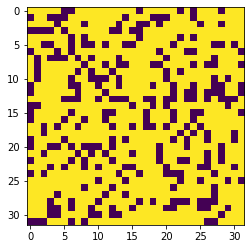

In [ ]:
N=32
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1
plt.imshow(lattice_p)

In [ ]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------



def initialstate(N):   
    ''' 
    Generates a random spin configuration for initial condition
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state



def mcmove(config, beta):
    '''
    Monte Carlo move using Metropolis algorithm 
    '''
    
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config



def calcEnergy(config):
    '''
    Energy of a given configuration
    '''
    energy = 0 
    
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/2.  # to compensate for over-counting



def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(config)
    return mag

def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()


get_energy(lattice_p)



-848.0

In [ ]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

/usr/local/lib/python3.7/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


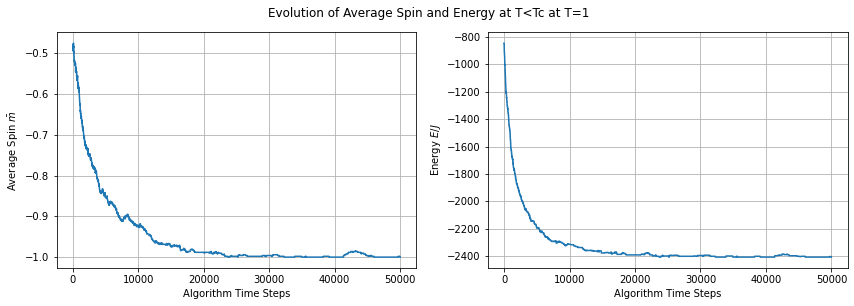

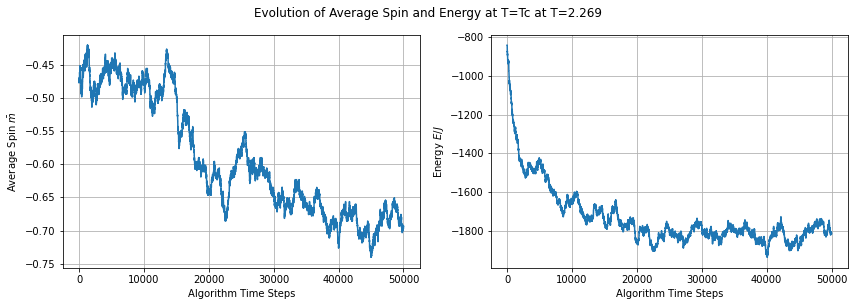

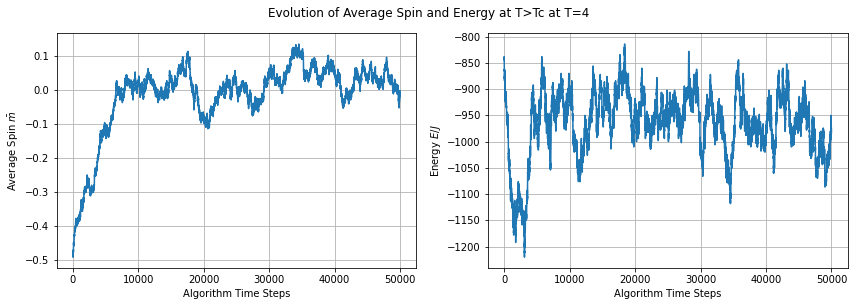

In [ ]:
spins, energies = metropolis(lattice_n, 50000, 1, get_energy(lattice_n))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy at T<Tc at T=1',y=1.05)
plt.show()

spins, energies = metropolis(lattice_n, 50000, 0.44068685453, get_energy(lattice_n))
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy at T=Tc at T=2.269',y=1.05)
plt.show()

spins, energies = metropolis(lattice_n, 50000, 0.25, get_energy(lattice_n))
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.suptitle(r'Evolution of Average Spin and Energy at T>Tc at T=4',y=1.05)
plt.show()



## Snapshots of the configurations


In [ ]:
%matplotlib inline
# Simulating the Ising model


class Ising():
    ''' Simulating the Ising model '''    
    
    
    ## monte carlo moves
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    

    
    def simulate(self,tt):   
        ''' This module simulates the Ising model'''
        N, temp     = 32, tt       # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1
        f = plt.figure(figsize=(15, 15), dpi=80);    
           
        msrmnt = 50001
        i=50000
        self.mcmove(config, N, 1.0/temp)
        self.configPlot(f, config, i, N, 6,tt);

                 
                    
    def configPlot(self, f, config, i, N, n_,tt):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        plt.title('Step=50000 for T=%f'%tt); plt.axis('tight')    
    plt.show()

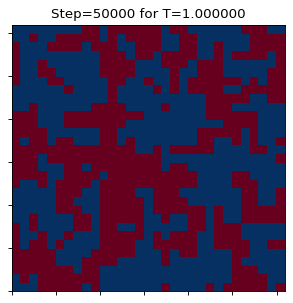

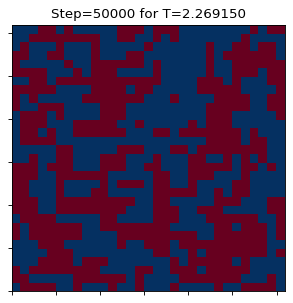

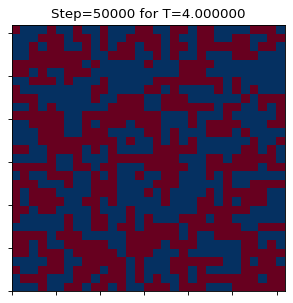

In [ ]:
rm = Ising()
rm.simulate(1)

rm2 = Ising()
rm2.simulate(2.26915)

rm3 = Ising()
rm2.simulate(4)



In [ ]:


nt      = 50         #  number of temperature points
N       = 32          #  size of the lattice, N x N
eqSteps = 5**2      #  number of MC sweeps for equilibration
mcSteps = 5**4       #  number of MC sweeps for calculation


T       = np.linspace(1.53, 2.78, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

In [ ]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------


for tt in range(nt):
    config = initialstate(N)         # initialise

    E1 = M1 = E2 = M2 = 0
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene


    # divide by number of sites and iteractions to obtain intensive values    
    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

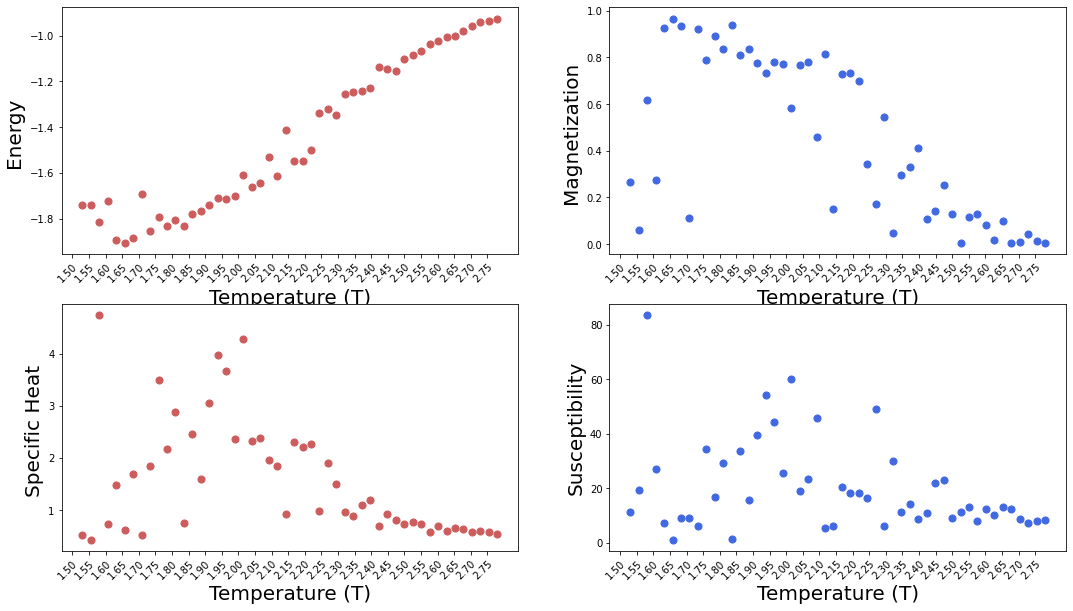

In [ ]:
#----------------------------------------------------------------------
#  plot the calculated values   
#----------------------------------------------------------------------

f = plt.figure(figsize=(18, 10)); #  


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.xticks(np.arange(1.5,2.80,0.05), rotation=45, ha='right', rotation_mode='anchor');


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');
plt.xticks(np.arange(1.5,2.80,0.05), rotation=45, ha='right', rotation_mode='anchor');


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   
plt.xticks(np.arange(1.5,2.80,0.05), rotation=45, ha='right', rotation_mode='anchor');


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');
plt.xticks(np.arange(1.5,2.80,0.05), rotation=45, ha='right', rotation_mode='anchor');

The quantities on the y-axis, in the above plots, are per spin. These intensive quantities have been plotted against temperature on the x-axis. It can be seen that the critical temperature for the numerical simulation of this small system is close to the known value of $T_c\sim2.269$ for a thermodynamic system.
